In [1]:
MDtrajs_dir="./MDtrajs/"
Featurization_dir="./Featurization/"
FSelection_dir = "./FSel/"
GMRQ_dir="./GMRQ/"
MicroMSM_dir='./MicroMSM/tica/'
MacroMSM_dir='./MacroGME/tica/'

### Construction of Macrostate MSM

In [3]:
import numpy as np
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus

In [ ]:
clustered_trajs = np.load(MicroMSM_dir + 'clustered_trajs.npy', allow_pickle=True)

msm = MarkovStateModel(n_timescales=10, lag_time=5, reversible_type='transpose',
                       verbose=False, ergodic_cutoff='off')
msm.fit(clustered_trajs)
pcca = PCCAPlus.from_msm(msm, n_macrostates=n_macro)
lumped_trajs = pcca.fit_transform(clustered_trajs)
lumped_trajs = np.array(lumped_trajs, dtype=object)
np.save(MacroMSM_dir + 'lumped_trajs.npy', lumped_trajs)

In [ ]:
def generate_TPM(trajs, lagtime):
    TPM = []
    for i in range(len(lagtime)):
        msm_macro = MarkovStateModel(n_timescales=3, lag_time=lagtime[i], 
                                     ergodic_cutoff='on', reversible_type='mle', verbose=False)
        msm_macro.fit(trajs)
        TPM.append(msm_macro.transmat_)
    return np.array(TPM)

n_macro = 4
lagtime = np.arange(5,1501,5)
TPM = generate_TPM(trajs = lumped_trajs, lagtime = lagtime)
np.save(MacroMSM_dir + 'TPM.npy', TPM)

num_runs = 50
num_samples_per_run = 150
bootstrap_TPM = np.zeros((num_runs, len(lagtime), n_macro, n_macro))
for i in range(num_runs):
    bootstrap_indices = np.random.choice(range(len(lumped_trajs)), 
                                         size=num_samples_per_run, replace=True)
    bootstrap_trajs = [lumped_trajs[i] for i in bootstrap_indices]
    bootstrap_TPM[i] = generate_TPM(bootstrap_trajs, lagtime=lagtime)
    print('Run {} is complete'.format(i))

np.save(MacroMSM_dir + 'bootstrap_TPM.npy', bootstrap_TPM)

### tICA Macro Model based on GME

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, './scripts')
from igme import IGMENS, IGME
from qmsm import MSM, QuasiMSM

In [3]:
TPM = np.load(MacroMSM_dir + "TPM.npy")
bootstrap_TPM = np.load(MacroMSM_dir + 'bootstrap_TPM.npy')

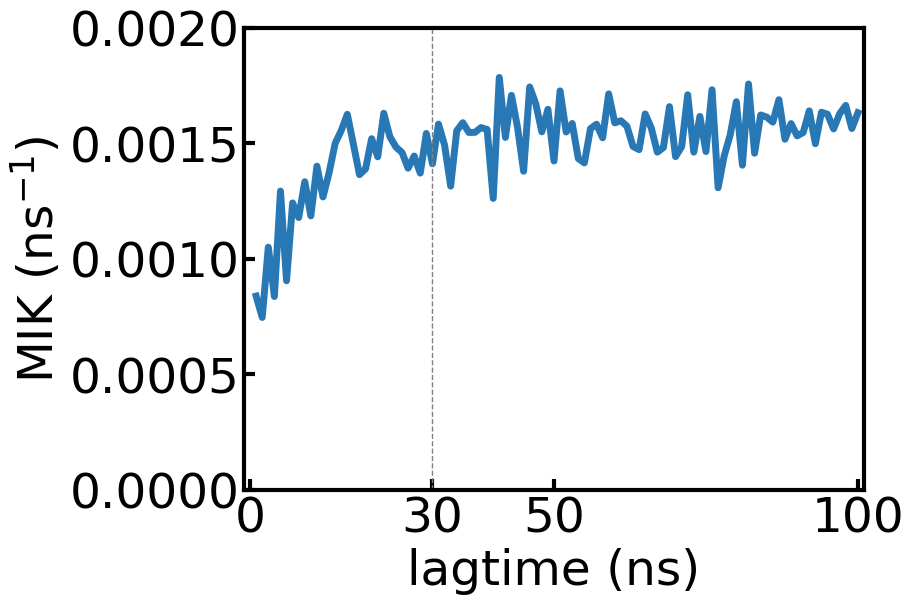

In [4]:
delta_t = 1 # unit: ns

# MIK computed from qMSM
qmsm = QuasiMSM()
lagtime = np.arange(1, 101) * delta_t
qmsm.fit(TPM, tau_k=100, delta_t=delta_t, rmse=False)

plt.rcParams['font.size'] = 35
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(lagtime, qmsm.mik, color='#2878B5', linewidth=5, label='qMSM')
plt.axvline(x=30, color='grey', linewidth=1, linestyle='--')
plt.ylim(0, 0.0020)
plt.xlim(-1, 101)
plt.xlabel('lagtime (ns)')
plt.ylabel('MIK (ns$^{-1}$)')
ax.tick_params(axis='both', direction='in', width=3, length=8)

ax.set_xticks(ticks=[0,30,50,100])
for spine in ax.spines.values():
    spine.set_linewidth(3)
# fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
# plt.savefig('./png/MIK_tica.png', dpi=1000, bbox_inches='tight')
plt.show()

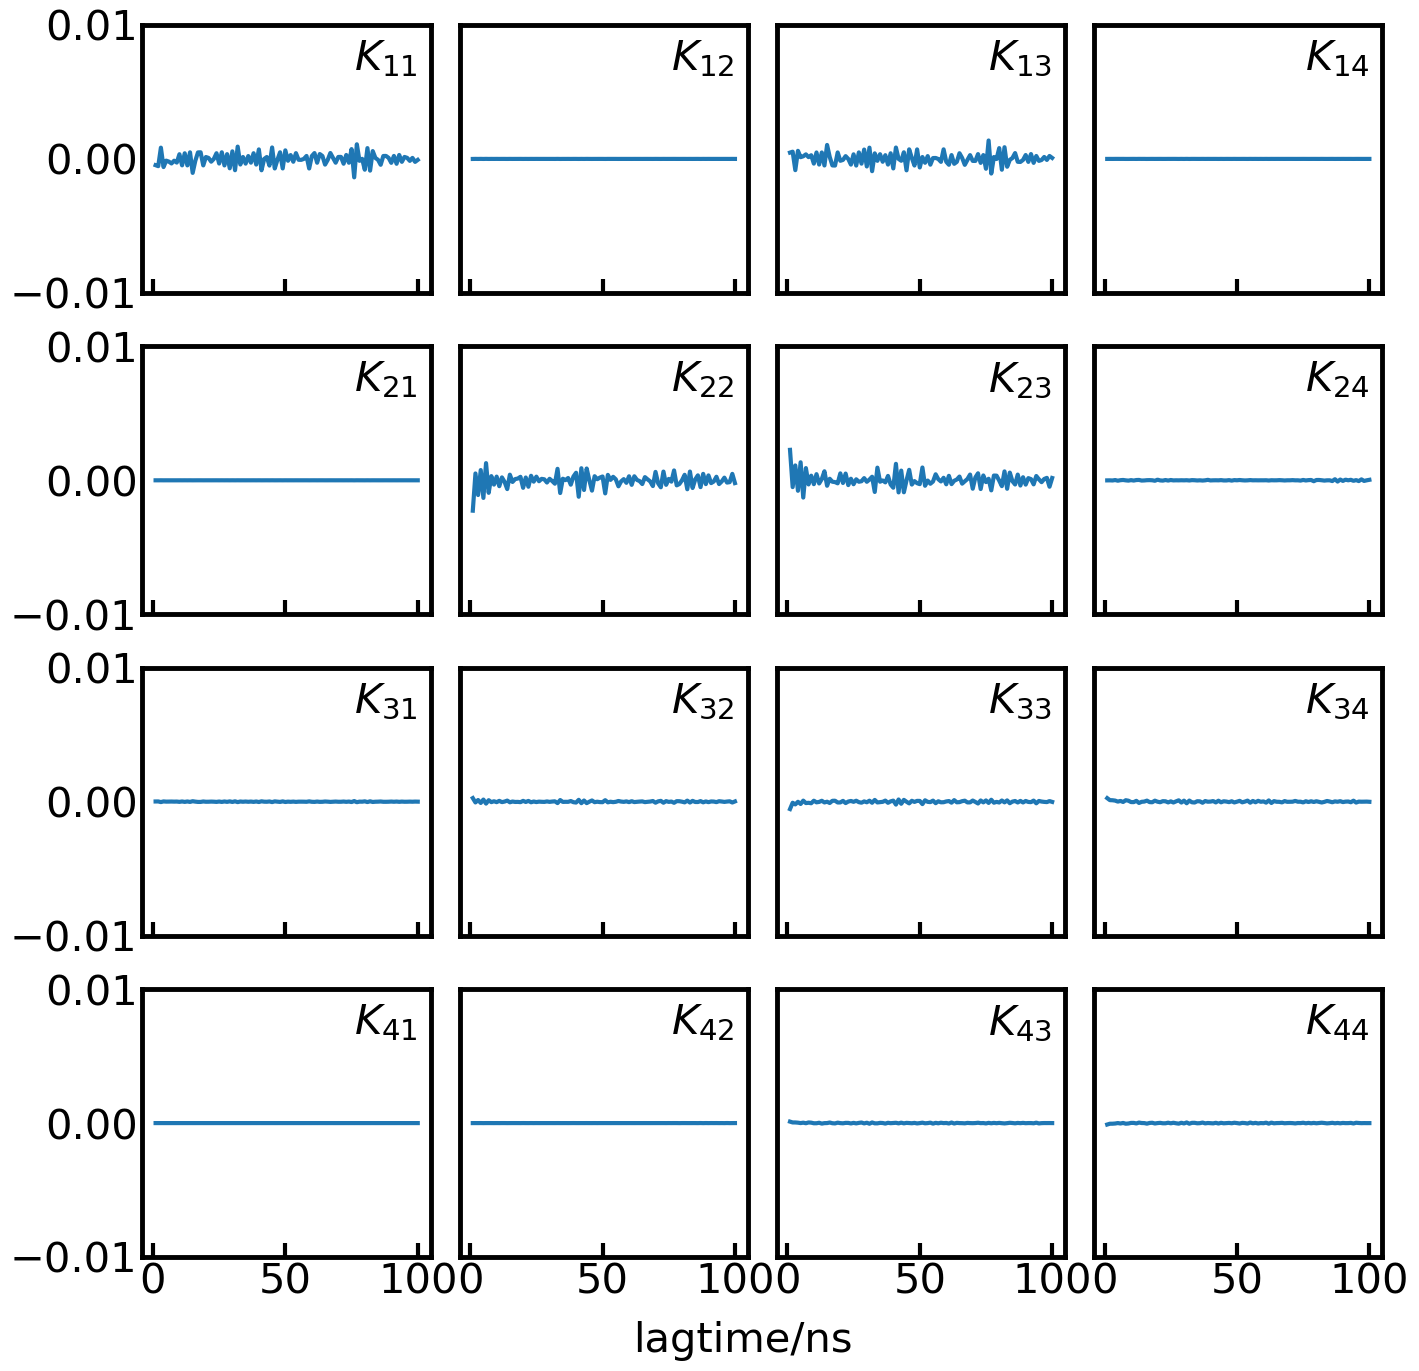

In [265]:
plt.rcParams['font.size'] = 30
fig, axes = plt.subplots(4,4,figsize=(16,16), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axes[i,j]
        ax.plot(lagtime, qmsm.K[:,i,j], linewidth=3)
        ax.set_ylim(-0.01,0.01)
        ax.tick_params(axis='x', direction='in', width=3, length=10)
        ax.tick_params(axis='y', direction='in', width=0, length=0)
        ax.set_xticks(ticks=[0,50,100], labels=[0,50,100])
        ax.text(100, 0.009, '$K_{{{}{}}}$'.format(i+1, j+1), ha='right',va='top')
#         ax.set_yticks(ticks=[0,0.5,1], labels=[0,0.5,1])
        for spine in ax.spines.values():
            spine.set_linewidth(3.5)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig.text(0.5, 0.07, 'lagtime/ns', ha='center', va='top')
plt.savefig('./png/K_matrix_tICA.png', dpi=1000, bbox_inches='tight')
plt.show()

In [5]:
# Compute RMSE of qMSM
qmsm = QuasiMSM()
qmsm.fit(TPM, tau_k=50, delta_t=1)
qmsm_rmse = qmsm.rmse

# Build qMSM
qmsm = QuasiMSM()
qmsm.fit(TPM, tau_k=30, delta_t=delta_t)
qmsm_time, qmsm_tpm = qmsm.predict(TPM) # Use qMSM for prediction
qmsm_its = qmsm.timescales(TPM, ITS_t=500) # ITS predicted by qMSM

In [6]:
# Scan tau_k and L of IGME
igme = IGME()
scan_output = igme.scan(input_data=TPM, begin=1, end=50)

# Build top IGME for CK-test
igme_top = igme.top_model(scan_output, 1) # Select the top IGME model
igme_tpm = np.array(igme_top.predict(1,len(TPM))) # Use IGME for prediction

# Compute MIK and ITS based on top 5% IGME models
top_outputs = igme.top_outputs(scan_output, n=0.05, max_its=1e5)
igme_mik = np.array(top_outputs['mik'])[:,1] / delta_t
igme_its = np.array(top_outputs['timescales']) * delta_t

In [7]:
# Compute RMSE of MSM
msm = MSM()
tau = np.arange(1, 151)
msm_rmse = msm.scan(TPM, delta_t=1, tau_lst=tau)

# Build 150 ns MSM
msm.fit(TPM, tau=150, delta_t = 1, rmse=True)
msm_time, msm_tpm = msm.predict(end=len(TPM))

In [8]:
np.savetxt(MacroMSM_dir + "qmsm_rmse.txt", qmsm_rmse)
np.savetxt(MacroMSM_dir + "msm_rmse.txt", msm_rmse)
np.savetxt(MacroMSM_dir + "igme_rmse.txt", scan_output['rmse'])

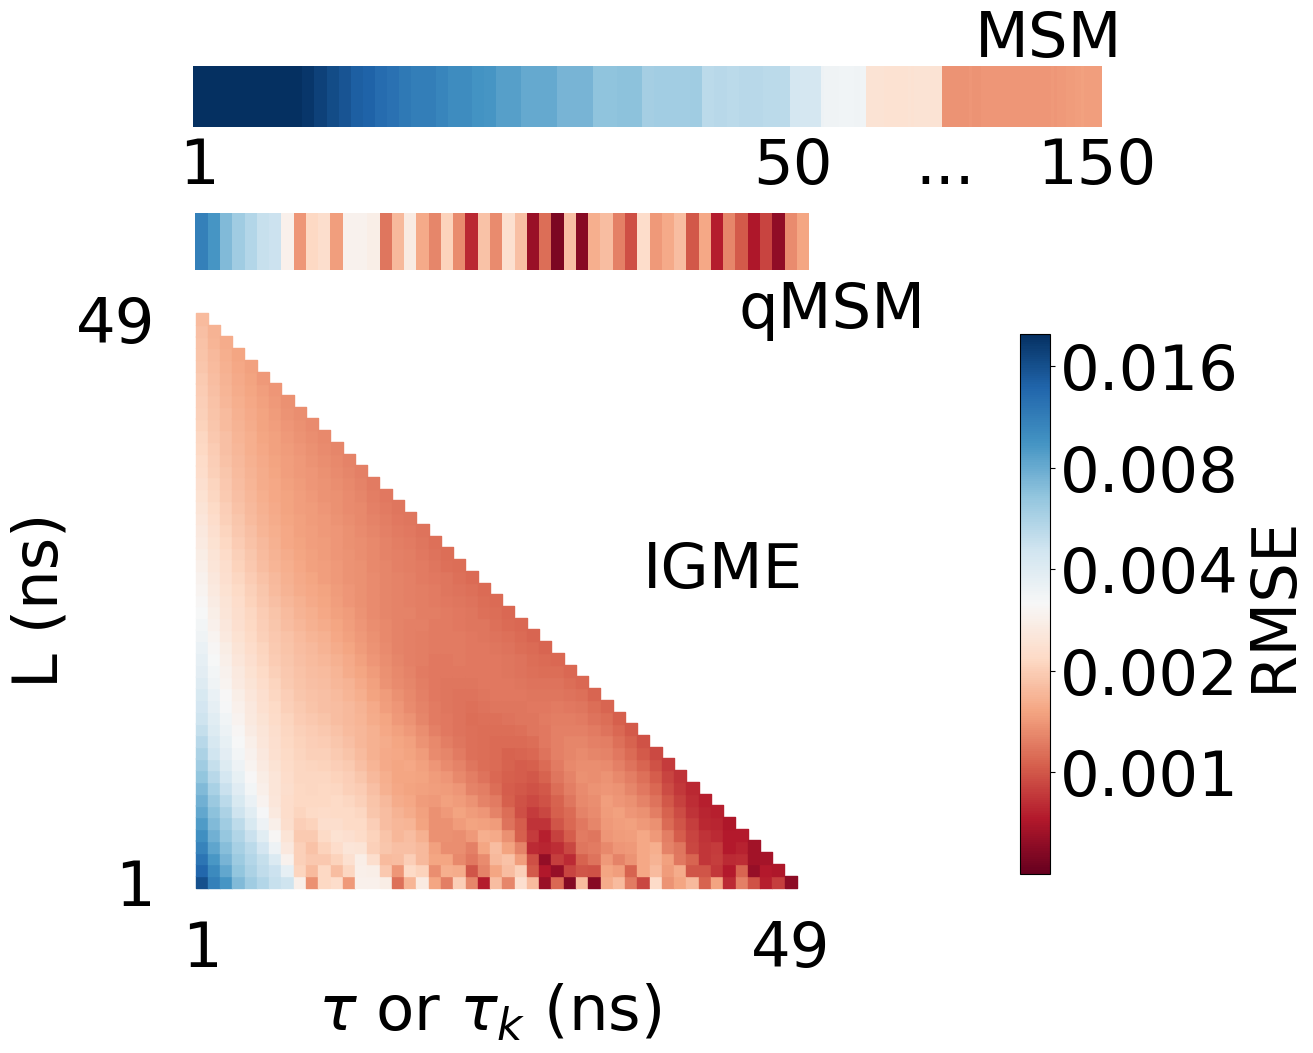

In [8]:
## Plot
def adjust_tau(x):
    if x < 50:
        return x
    else:
        return x/4 + 37.5
    
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

x = [i for i in scan_output['begin']]
y = [(scan_output['end'][i] - scan_output['begin'][i]) for i in range(len(x))]
z = scan_output['rmse']

plt.rcParams['font.size'] = 45
cmap_name = 'RdBu'  # You can use any colormap of your choice from Matplotlib's colormaps
custom_cmap = plt.get_cmap(cmap_name)
norm = mcolors.LogNorm(vmin=5e-4, vmax=2e-2)

fig, axes = plt.subplots(2, 1, figsize=(10,9), sharex=True,
                         gridspec_kw={'height_ratios': [1, 7]})

qmsm_color_bar = custom_cmap(norm(qmsm_rmse))
qmsm_tauk_time = np.arange(1, 51, 1)
upper_bound = np.ones(len(qmsm_color_bar))*1.6
axes[0].bar(qmsm_tauk_time, upper_bound, color=qmsm_color_bar, width=1)
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].set_ylim(-0.5, 2)
axes[0].text(60, -2, 'qMSM', ha='right', va='bottom')
axes[0].set_frame_on(False)
axes[0].tick_params(left=False, right=False, bottom=False, top=False)

axes[1].scatter(x, y, c=z,
                cmap=custom_cmap, norm=norm, marker='s', s=75)
axes[1].text(50, 25, 'IGME', ha='right', va='bottom')
axes[1].set_frame_on(False)
axes[1].tick_params(left=False, right=False, bottom=False, top=False)
axes[1].set_xticks([1, 49])
axes[1].set_yticks([1, 49])
# axes[1].set_xlabel('\u03C4 or \u03C4_k /ps')
fig.text(0.45, 0.03, '$\\tau$ or $ \\tau_k $ (ns)', ha='center', va='top')
axes[1].set_ylabel('L (ns)')
# Create the colorbar using ScalarMappable

plt.subplots_adjust(hspace=0.01)
fig.subplots_adjust(top=0.9)
msm_ax = fig.add_axes([0.108, 0.98, 1, 0.13])
tau = np.arange(1, 151)
upper_bound = np.ones(len(tau))*0.52
msm_color_bar = custom_cmap(norm(msm_rmse))
msm_ax.bar([adjust_tau(i) for i in tau], upper_bound, color=msm_color_bar, width=1)
msm_ax.set_yticks([])
msm_ax.set_xticks([])
msm_ax.set_ylim(0, 1)
msm_ax.set_xticks([1,50, 62.5, 75], labels=[1,50,"...",150])
msm_ax.text(65,0.6,'MSM')
msm_ax.set_frame_on(False)
msm_ax.tick_params(left=False, right=False, bottom=False, top=False)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.98, 0.15, 0.03, 0.6])

# cax = axes[2,1].inset_axes([0.5, 0.2, 0.5, 1])  # [x, y, width, height]
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=cbar_ax)
ticks = [1e-3, 2e-3, 4e-3, 8e-3, 1.6e-2]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.ax.minorticks_off()
cbar.set_label('RMSE')

# plt.savefig('./png/RMSE_tICA.png', dpi=500, bbox_inches='tight')
plt.show()

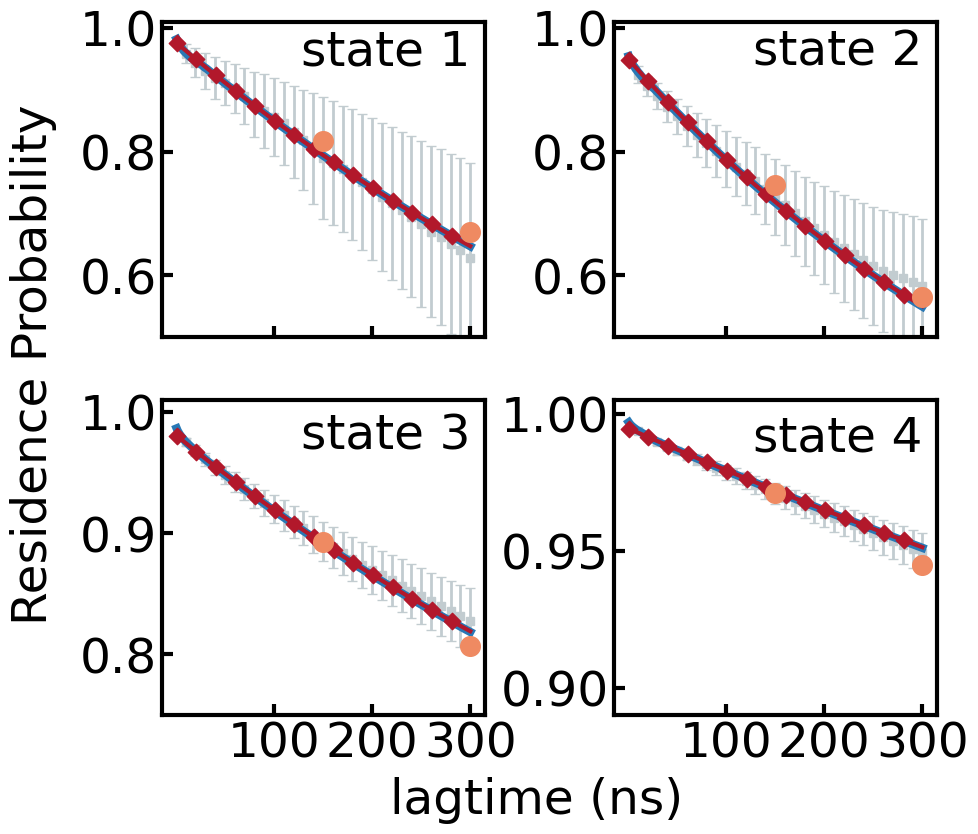

In [9]:
# CK test

plt.rcParams['font.size'] = 35

length = 300
lt = np.arange(1,length+1) 
n_state = 4

TPM_mean = np.mean(bootstrap_TPM, axis=0)
TPM_std = np.std(bootstrap_TPM, axis=0)
fig, axes = plt.subplots(2,2,figsize=(10,9), sharex=True)
for i in range(n_state):
    ax = axes[i//2, i-(i//2)*2]
    ax.errorbar(x=lt[-1::-10], y=TPM_mean[-1::-10,i,i], yerr=TPM_std[-1::-10,i,i],
                fmt='s', capsize=3.5, elinewidth=2, ecolor='#c2ccd0', color='#c2ccd0',
                zorder=0) 
    ax.plot(qmsm_time, qmsm_tpm[:,i,i], color='#2878B5', linewidth=6, zorder=2)
    
    ax.plot(lt, igme_tpm[:length,i,i], color='#b2182b', linewidth=3, zorder=3)
    ax.scatter(lt[::20], igme_tpm[::20,i,i], c='#b2182b', marker='D', s=70, zorder=3)
    
    ax.scatter(msm_time, msm_tpm[:,i,i], c='#ef8a62', s=200, zorder=4)
    ax.text(300, 1, 'state {}'.format(i+1), ha='right',va='top')
    

    ax.tick_params(axis='both', direction='in', width=3, length=8)
    ax.set_xticks(ticks=[100,200,300],labels=[100,200,300] )
    for spine in ax.spines.values():
        spine.set_linewidth(3)

axes[0, 0].set_ylim(0.5, 1.01)
axes[0, 1].set_ylim(0.5, 1.01)
axes[1, 0].set_ylim(0.75, 1.01)
axes[1, 1].set_ylim(0.89, 1.005)

plt.scatter([], [], c='#ef8a62', s=200, label='MSM')
plt.plot([], [], label='qMSM', color='#2878B5', linewidth=6)        
plt.errorbar([], [], xerr=[], color='#b2182b', label='IGME', fmt='D',
             markersize=10, elinewidth=3, capsize=3)
plt.errorbar([], [], yerr=[], color='#c2ccd0', label='MD', fmt='s',
             markersize=15, elinewidth=3, capsize=3)
fig.text(0.5, 0, 'lagtime (ns)', ha='center')
fig.text(0.02, 0.5, "Residence Probability", ha='right', va='center', rotation=90)
# plt.tight_layout()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4)
plt.subplots_adjust(wspace=0.4)
# plt.savefig('./png/tica_macroCK.png', dpi=1000, bbox_inches='tight')
plt.show()

In [10]:
# The timescales
print("Implied Timescales of 150 ns MSM:")
print(msm.timescales)

print("\nImplied Timescales of qMSM at 500 ns:")
print(qmsm_its)

print("\nImplied Timescales of IGME:")
print(igme_top.timescales)

print("\nThe mean values of the implied timescales among the top 5% IGME models: ")
print(np.mean(np.array(top_outputs['timescales']), axis=0))

print("\nThe standard deviation of the implied timescales among the top 5% IGME models: ")
print(np.std(np.array(top_outputs['timescales']), axis=0))

Implied Timescales of 150 ns MSM:
[1616.89871079  717.61041494  428.79364058]

Implied Timescales of qMSM at 500 ns:
[1865.00672592  677.80544995  427.74915235]

Implied Timescales of IGME:
[1987.68130495  700.76225372  450.5757072 ]

The mean values of the implied timescales among the top 5% IGME models: 
[1954.90144739 1229.72040282  494.2875562 ]

The standard deviation of the implied timescales among the top 5% IGME models: 
[295.11713357 293.11476465  43.36143919]


In [11]:
# RMSE
print("RMSE of 150 ns MSM:")
print(msm.rmse)

print("\nRMSE of qMSM:")
print(qmsm.rmse[-1])

print("\nRMSE of IGME:")
print(igme_top.rmse)

print("\nThe RMSE among the top 5% IGME models fall below: ")
print(np.max(top_outputs['rmse']))

RMSE of 150 ns MSM:
0.0014699248812675143

RMSE of qMSM:
0.000565605337877919

RMSE of IGME:
0.0005809222297839731

The RMSE among the top 5% IGME models fall below: 
0.0009252083257546923


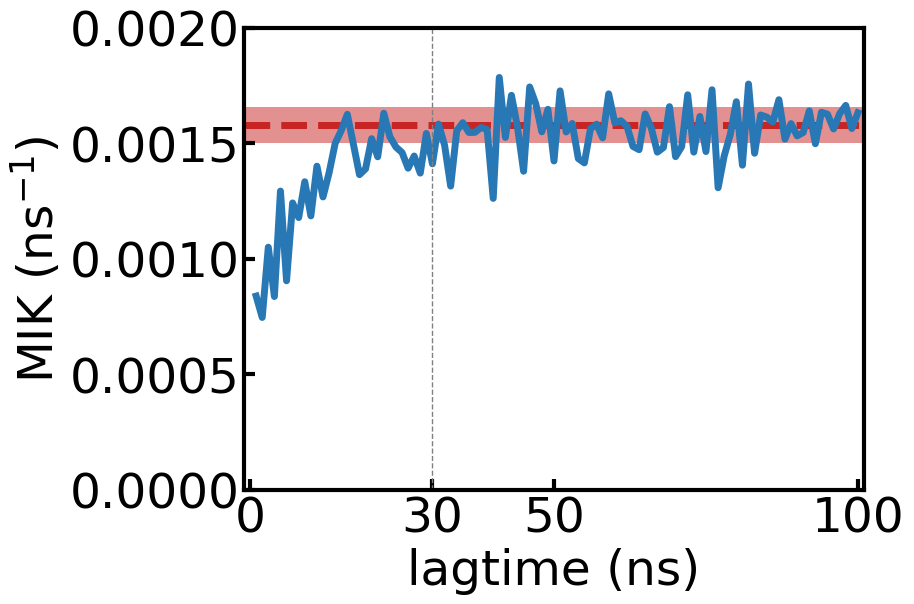

In [12]:
delta_t = 1

# MIK computed from qMSM
qmsm = QuasiMSM()
lagtime = np.arange(1, 101) * delta_t
qmsm.fit(TPM, tau_k=100, delta_t=delta_t, rmse=False)
mik_mean = np.mean(np.array(top_outputs['mik'])[:,1])
mik_std = np.std(np.array(top_outputs['mik'])[:,1])

plt.rcParams['font.size'] = 35
fig, ax = plt.subplots(figsize=(8,6))
plt.fill_between(np.linspace(-1, 101, 100),mik_mean-mik_std, mik_mean+mik_std, color='#C82423', alpha=0.5, linewidth=0)
plt.axhline(y=mik_mean, color='#C82423', linestyle='--', linewidth=5)
plt.plot(lagtime, qmsm.mik, color='#2878B5', linewidth=5, label='qMSM')
plt.axvline(x=30, color='grey', linewidth=1, linestyle='--')
plt.ylim(0, 0.0020)
plt.xlim(-1, 101)
plt.xlabel('lagtime (ns)')
plt.ylabel('MIK (ns$^{-1}$)')
ax.tick_params(axis='both', direction='in', width=3, length=8)

ax.set_xticks(ticks=[0,30,50,100])
for spine in ax.spines.values():
    spine.set_linewidth(3)
# fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
# plt.savefig('./png/MIK_tica.png', dpi=1000, bbox_inches='tight')
plt.show()